## Random Forest Implementation on scaled reduced dataset with SVD

Imports

In [1]:
# Utilities
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Models
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

C:\Users\movil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Set random seed for reproductibility

In [2]:
seed = 23

Read clean (scaled data)

In [3]:
df_scaled = pd.read_csv('../../Data/dataset_preprocessed.csv')

Read Train Data

In [4]:
X_train= pd.read_csv('../../DimensionalityReductionData/X_train_SVD.csv')
X_train.head()

,Dimension 1,Dimension 2
0,1.103460,0.072267
1,1.461354,-0.592586
2,1.647283,0.088656
3,1.676719,-0.541218
4,1.570116,-0.572993


Read Test Data

In [5]:
X_test = pd.read_csv('../../DimensionalityReductionData/X_test_SVD.csv')
X_test.head()

,Dimension 1,Dimension 2
0,1.220573,0.206269
1,1.250327,-0.570413
2,1.368459,-0.546002
3,1.277790,0.761160
4,1.636357,0.070829


Do Train-Test Split to define y_train, y_test (both are raings)
!!!! IMPORTANT use random_state as defined in Dimension Reduction DATA SPLIT!!!!

In [6]:
y_train, y_test = train_test_split(df_scaled['averageRating'], test_size=0.2, random_state=42)

Now everything is defined (X_train, X_test, y_train, y_test)

Save and print metrics

In [7]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None, zero_division=0)),
    }
    
    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")
    
    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()
    
    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()
    
    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])
    
    return df_metrics

In [8]:
model = RandomForestClassifier(n_estimators=100, random_state=seed)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))

print("F1 score:", f1_score(y_test, predictions, average=None))

Accuracy: 0.5919387075283145
F1 score: [0.59796521 0.58572878]


## Grid Search CV - 1

In [9]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

model = RandomForestClassifier(random_state=seed)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("The parameters with the highest score: ", grid_search.best_params_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
The parameters with the highest score:  {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


In [10]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Show top 10 parameters for this model
minimalistic_results = cv_results_df[['params', 'mean_test_score']]
sorted_results = minimalistic_results.sort_values(by='mean_test_score', ascending=False)

print(sorted_results.head(10))

                                               params  mean_test_score
67  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.616743
63  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.616743
49  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.616659
47  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.616576
43  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.616326
69  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.615993
70  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.615993
51  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.615909
42  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.615743
66  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.615660


Metrics for RF-SVD-GS-CV1:
Accuracy: 0.6209
Weighted F1: 0.6198
Weighted Precision: 0.6246
Weighted Recall: 0.6209
Macro-Averaged Precision: 0.6239
Macro-Averaged Recall: 0.6224
F1: [0.60348432 0.63688577]
Precision: [0.65063862 0.59724716]
classification report
              precision    recall  f1-score   support

     Class 0       0.65      0.56      0.60      1539
     Class 1       0.60      0.68      0.64      1463

    accuracy                           0.62      3002
   macro avg       0.62      0.62      0.62      3002
weighted avg       0.62      0.62      0.62      3002

Confusion Matrix


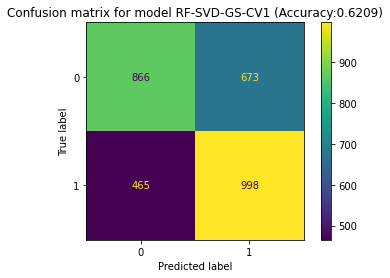

In [11]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
_ = calculate_metrics('RF-SVD-GS-CV1', y_test, predictions)

In [12]:
# Predicting using other alternatives of fine-tuning from top 10 performances
other_alternatives = []
# Choose a set of parameters from sorted_results
for i in range(10):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = RandomForestClassifier(random_state=seed, **params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)

  chosen_accuracy = accuracy_score(y_test, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)
  other_alternatives.append((chosen_accuracy,params))


Parameters from place:  0   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for chosen parameters: 0.6209193870752832
Parameters from place:  1   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy for chosen parameters: 0.6209193870752832
Parameters from place:  2   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy for chosen parameters: 0.6215856095936043
Parameters from place:  3   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy for chosen parameters: 0.6239173884077281
Parameters from place:  4   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for chosen parameters: 0.6229180546302465
Parameters from place:  5   {'bootstrap': True, 'max_depth': 10, 'min_samples_le

In [13]:
# get best from top 10
best_tuple = max(other_alternatives, key=lambda x: x[0])

In [14]:
print("Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances")
print(best_tuple[0])
print(best_tuple[1])

Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances
0.6239173884077281
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [15]:
# Run on training sample

# Choose a set of parameters from sorted_results
for i in range(10):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = RandomForestClassifier(random_state=42, **params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_train)

  chosen_accuracy = accuracy_score(y_train, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)

Parameters from place:  0   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for chosen parameters: 0.6834652228238234
Parameters from place:  1   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy for chosen parameters: 0.6834652228238234
Parameters from place:  2   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy for chosen parameters: 0.6902957101207831
Parameters from place:  3   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy for chosen parameters: 0.6842149104539775
Parameters from place:  4   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for chosen parameters: 0.6920449812578092
Parameters from place:  5   {'bootstrap': True, 'max_depth': 10, 'min_samples_le

In [16]:
accuracies=[]
max_depths=[]
for i in reversed(range(1,15)):
  model = RandomForestClassifier(random_state=seed, max_depth=i)
  model.fit(X_train, y_train)
  predictions = model.predict(X_train)
  accuracy = accuracy_score(y_train, predictions)
  max_depths.append(i)
  accuracies.append(accuracy)
  print("Accuracy for max depth :", i, " ", accuracy)

Accuracy for max depth : 14   0.8142440649729279
Accuracy for max depth : 13   0.7806747188671387
Accuracy for max depth : 12   0.7542690545605998
Accuracy for max depth : 11   0.7258642232403165
Accuracy for max depth : 10   0.6980424822990421
Accuracy for max depth : 9   0.6790503956684715
Accuracy for max depth : 8   0.6613910870470637
Accuracy for max depth : 7   0.6480633069554352
Accuracy for max depth : 6   0.6384006663890046
Accuracy for max depth : 5   0.6244064972927946
Accuracy for max depth : 4   0.6199083715118701
Accuracy for max depth : 3   0.5979175343606831
Accuracy for max depth : 2   0.5938359017076218
Accuracy for max depth : 1   0.5940024989587672


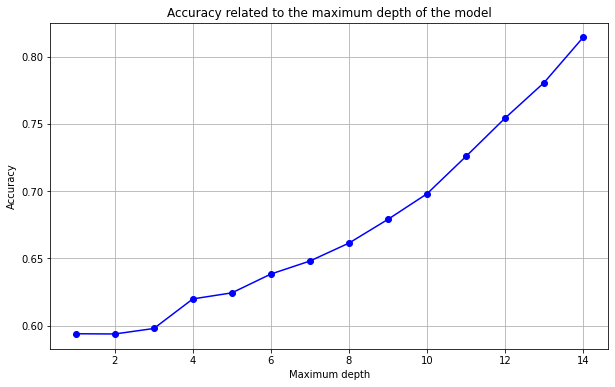

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(max_depths, accuracies, marker='o', linestyle='-', color='b')

plt.title('Accuracy related to the maximum depth of the model')
plt.xlabel('Maximum depth')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

Classification report of best model from alternatives of fine tuning

In [18]:
model = RandomForestClassifier(random_state=seed, **best_tuple[1])
model.fit(X_train, y_train)

predictions = model.predict(X_test)
current_accuracy = accuracy_score(y_test, predictions)

report = classification_report(y_test, predictions, output_dict=True, zero_division=0)


In [19]:
print(classification_report(y_test, predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.66      0.56      0.61      1539
           1       0.60      0.69      0.64      1463

    accuracy                           0.62      3002
   macro avg       0.63      0.63      0.62      3002
weighted avg       0.63      0.62      0.62      3002



Metrics for RF-SVD-alternatives:
Accuracy: 0.6239
Weighted F1: 0.6226
Weighted Precision: 0.6280
Weighted Recall: 0.6239
Macro-Averaged Precision: 0.6273
Macro-Averaged Recall: 0.6255
F1: [0.60510668 0.64101749]
Precision: [0.65530303 0.59928656]
classification report
              precision    recall  f1-score   support

     Class 0       0.66      0.56      0.61      1539
     Class 1       0.60      0.69      0.64      1463

    accuracy                           0.62      3002
   macro avg       0.63      0.63      0.62      3002
weighted avg       0.63      0.62      0.62      3002

Confusion Matrix


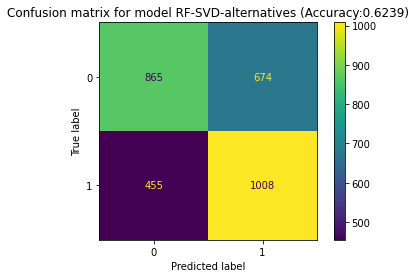

,Accuracy,Weighted F1,Weighted Precision,Weighted Recall,Macro-Averaged Precision,Macro-Averaged Recall,F1,Precision
RF-SVD-alternatives,0.623917,0.622608,0.628004,0.623917,0.627295,0.625524,[0.60510668 0.64101749],[0.65530303 0.59928656]


In [20]:
calculate_metrics('RF-SVD-alternatives', y_test, predictions)